In [1]:
import pandas as pd
import seaborn as sns

# Load dataset
df = pd.read_excel("PJMW_MW_Hourly.xlsx")

In [2]:
df

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077
1,2002-12-31 02:00:00,4939
2,2002-12-31 03:00:00,4885
3,2002-12-31 04:00:00,4857
4,2002-12-31 05:00:00,4930
...,...,...
143201,2018-01-01 20:00:00,8401
143202,2018-01-01 21:00:00,8373
143203,2018-01-01 22:00:00,8238
143204,2018-01-01 23:00:00,7958


In [3]:
df.describe()

,Datetime,PJMW_MW
count,143206,143206.000000
mean,2010-06-02 03:39:50.656816128,5602.375089
min,2002-04-01 01:00:00,487.000000
25%,2006-05-02 03:15:00,4907.000000
50%,2010-06-02 04:30:00,5530.000000
75%,2014-07-03 06:45:00,6252.000000
max,2018-08-03 00:00:00,9594.000000
std,NaN,979.142872


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  143206 non-null  datetime64[ns]
 1   PJMW_MW   143206 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.2 MB
None


In [5]:
print(df.head)

<bound method NDFrame.head of                   Datetime  PJMW_MW
0      2002-12-31 01:00:00     5077
1      2002-12-31 02:00:00     4939
2      2002-12-31 03:00:00     4885
3      2002-12-31 04:00:00     4857
4      2002-12-31 05:00:00     4930
...                    ...      ...
143201 2018-01-01 20:00:00     8401
143202 2018-01-01 21:00:00     8373
143203 2018-01-01 22:00:00     8238
143204 2018-01-01 23:00:00     7958
143205 2018-01-02 00:00:00     7691

[143206 rows x 2 columns]>


In [6]:
print(df.shape)

(143206, 2)


*1*. Check Missing Values

In [7]:
# Convert Datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])


In [8]:
# Check missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Datetime    0
PJMW_MW     0
dtype: int64


2. Create Time Features

In [9]:
# Create time-related features
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour
df['weekday'] = df['Datetime'].dt.day_name()


3. Trend and Seasonality Patterns (Decomposition)

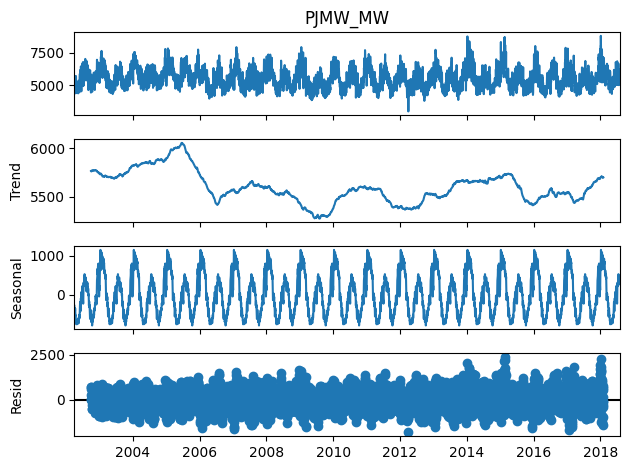

In [10]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Ensure Datetime is in correct format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Ensure PJMW_MW is numeric
df['PJMW_MW'] = pd.to_numeric(df['PJMW_MW'], errors='coerce')

# Drop any rows with missing values
df = df.dropna(subset=['Datetime', 'PJMW_MW'])

# Set datetime as index
df = df.set_index('Datetime')

# Resample to daily mean
daily_series = df['PJMW_MW'].resample('D').mean()

# Decomposition
decomposition = seasonal_decompose(daily_series, model='additive', period=365)
decomposition.plot()
plt.tight_layout()
plt.show()


4. Hourly, Daily, Monthly Trends

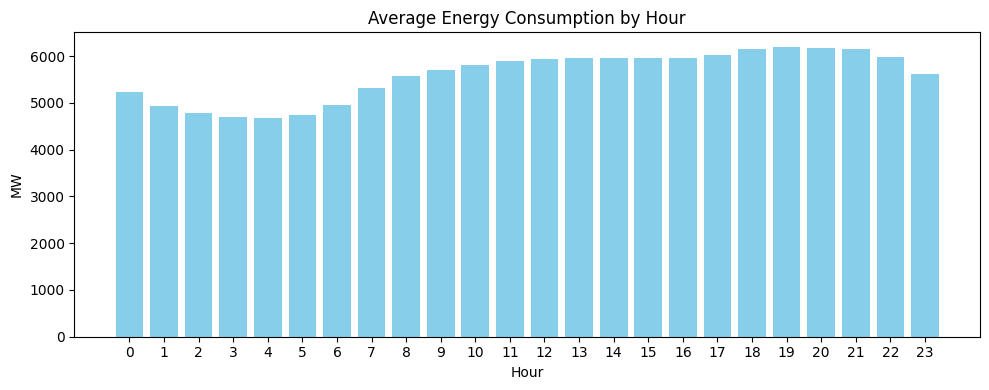

<ipython-input-11-e6b932d91ac6>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df['PJMW_MW'].resample('M').mean()


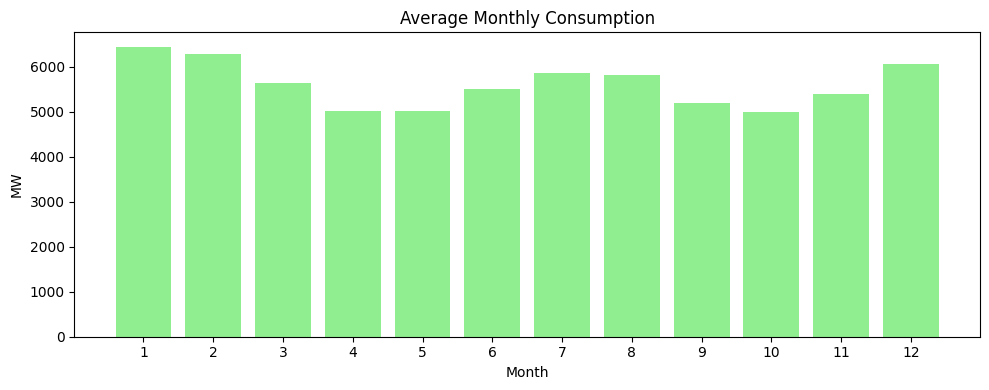

In [11]:
import matplotlib.pyplot as plt

# Hourly Trend
df['hour'] = df.index.hour  # since Datetime is now index
hourly_avg = df.groupby('hour')['PJMW_MW'].mean()

plt.figure(figsize=(10, 4))
plt.bar(hourly_avg.index, hourly_avg.values, color='skyblue')
plt.title('Average Energy Consumption by Hour')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Monthly Trend
monthly_avg = df['PJMW_MW'].resample('M').mean()
monthly_avg.index = monthly_avg.index.month
monthly_mean = monthly_avg.groupby(monthly_avg.index).mean()

plt.figure(figsize=(10, 4))
plt.bar(monthly_mean.index, monthly_mean.values, color='lightgreen')
plt.title('Average Monthly Consumption')
plt.xlabel('Month')
plt.ylabel('MW')
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()


5. Holiday Effects

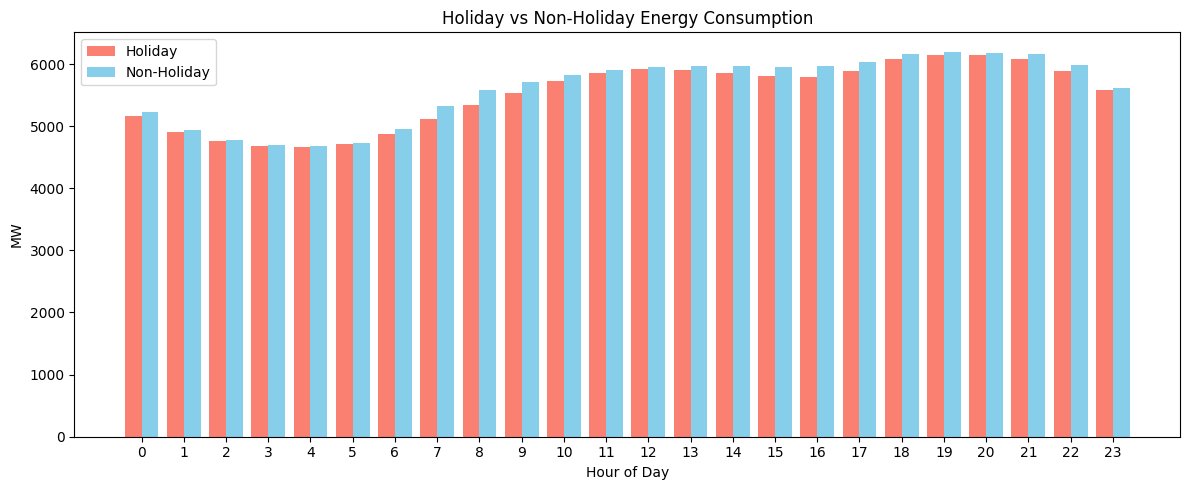

In [12]:
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# Create US federal holiday calendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=df.index.min(), end=df.index.max())

# Mark holidays
df['is_holiday'] = df.index.normalize().isin(holidays)

# Add hour column
df['hour'] = df.index.hour

# Group by hour for holiday and non-holiday
holiday_avg = df[df['is_holiday']].groupby('hour')['PJMW_MW'].mean()
non_holiday_avg = df[~df['is_holiday']].groupby('hour')['PJMW_MW'].mean()

# Bar plot
plt.figure(figsize=(12, 5))
plt.bar(holiday_avg.index - 0.2, holiday_avg.values, width=0.4, label='Holiday', color='salmon', align='center')
plt.bar(non_holiday_avg.index + 0.2, non_holiday_avg.values, width=0.4, label='Non-Holiday', color='skyblue', align='center')
plt.title('Holiday vs Non-Holiday Energy Consumption')
plt.xlabel('Hour of Day')
plt.ylabel('MW')
plt.xticks(range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()


 Compare Weekends vs Weekdays

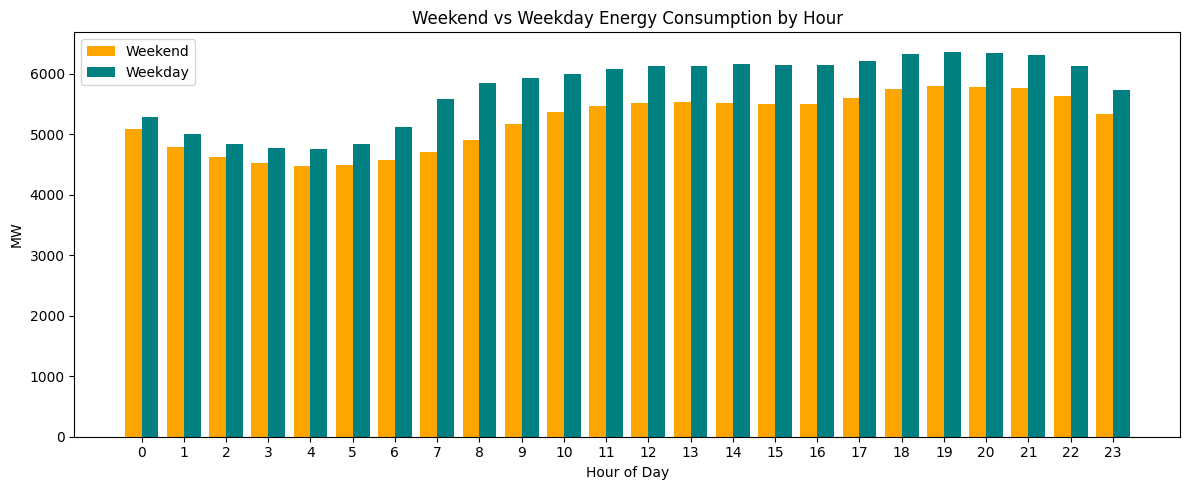

In [13]:
# Create 'weekday' feature (0=Monday, 6=Sunday)
df['weekday_num'] = df.index.weekday
df['is_weekend'] = df['weekday_num'] >= 5  # Saturday and Sunday

# Group by hour for weekend and weekday
weekend_avg = df[df['is_weekend']].groupby('hour')['PJMW_MW'].mean()
weekday_avg = df[~df['is_weekend']].groupby('hour')['PJMW_MW'].mean()

# Bar plot
plt.figure(figsize=(12, 5))
plt.bar(weekend_avg.index - 0.2, weekend_avg.values, width=0.4, label='Weekend', color='orange', align='center')
plt.bar(weekday_avg.index + 0.2, weekday_avg.values, width=0.4, label='Weekday', color='teal', align='center')
plt.title('Weekend vs Weekday Energy Consumption by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('MW')
plt.xticks(range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()


Compare Each Day of the Week

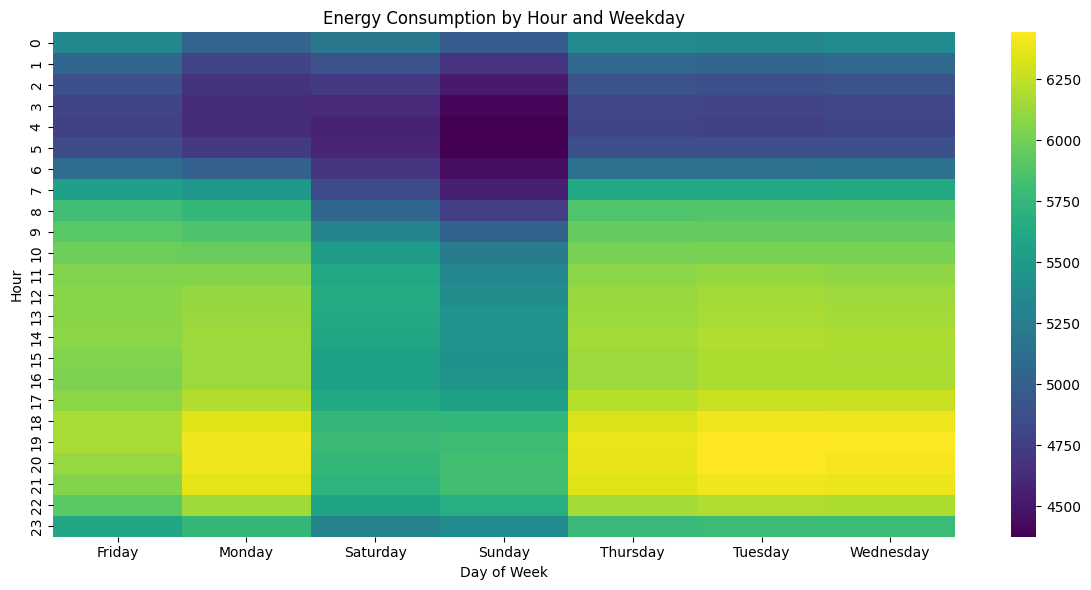

In [14]:
# Group by weekday name and hour
weekday_hourly = df.groupby([df.index.day_name(), 'hour'])['PJMW_MW'].mean().reset_index()

# Pivot for heatmap
pivot_table = weekday_hourly.pivot(index='hour', columns='Datetime', values='PJMW_MW')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='viridis')
plt.title('Energy Consumption by Hour and Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Hour')
plt.tight_layout()
plt.show()


6. Correlation with Time Features

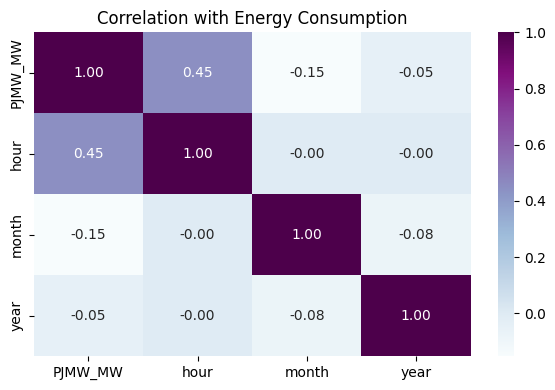

In [15]:
# Calculate correlation
corr = df[['PJMW_MW', 'hour', 'month', 'year']].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='BuPu', fmt=".2f")
plt.title('Correlation with Energy Consumption')
plt.tight_layout()
plt.show()


 1. Seasonal Decomposition

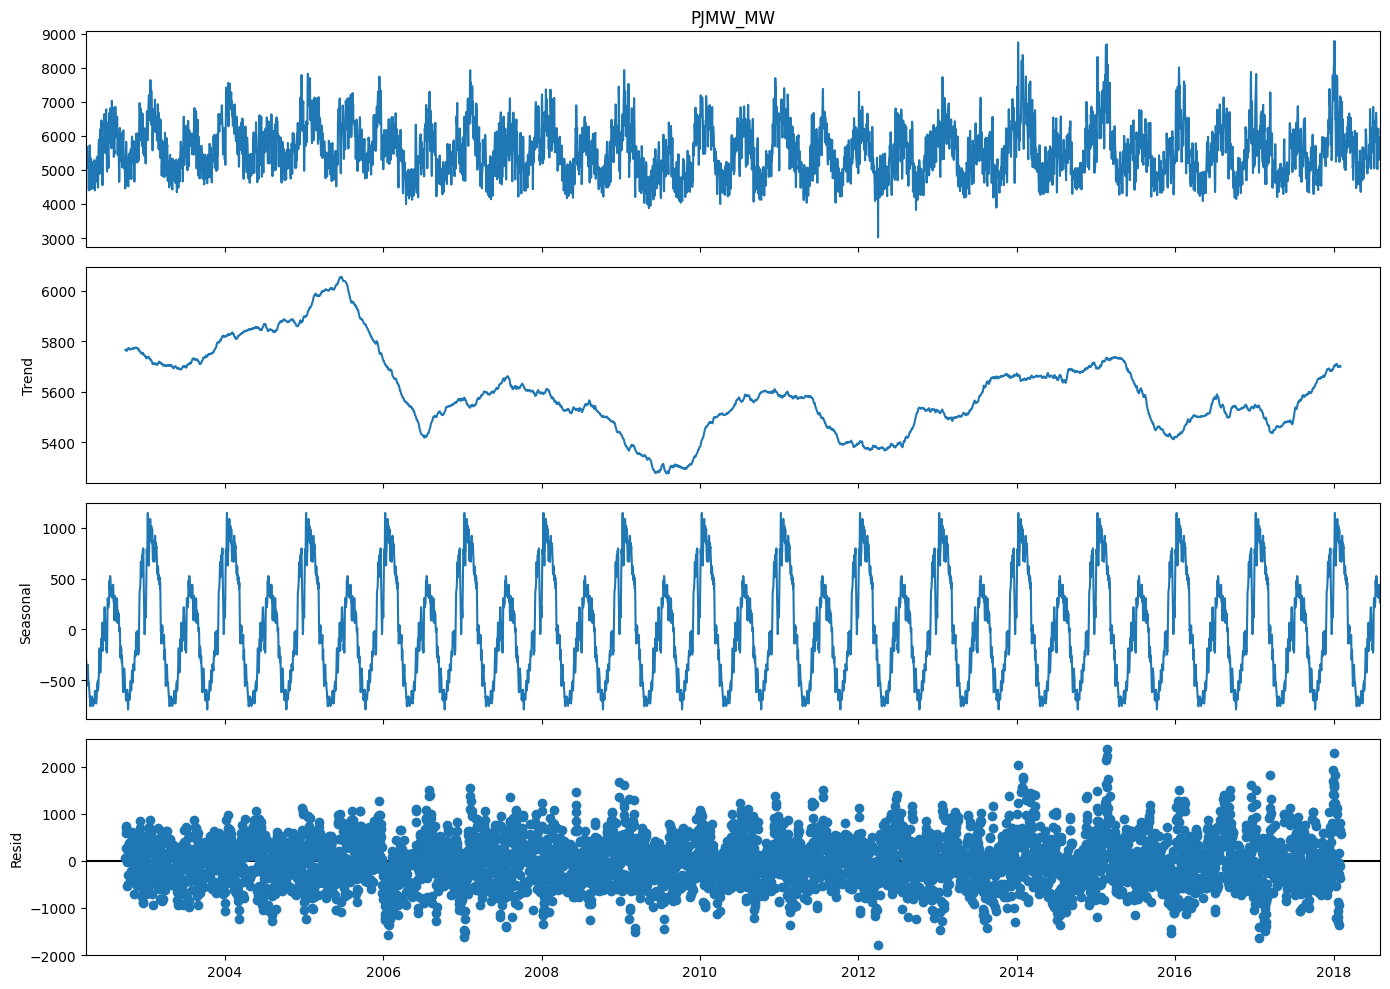

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Resample to daily data
daily_series = df['PJMW_MW'].resample('D').mean()

# Perform decomposition
decomposition = seasonal_decompose(daily_series, model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()


2. Holiday Effects Analysis

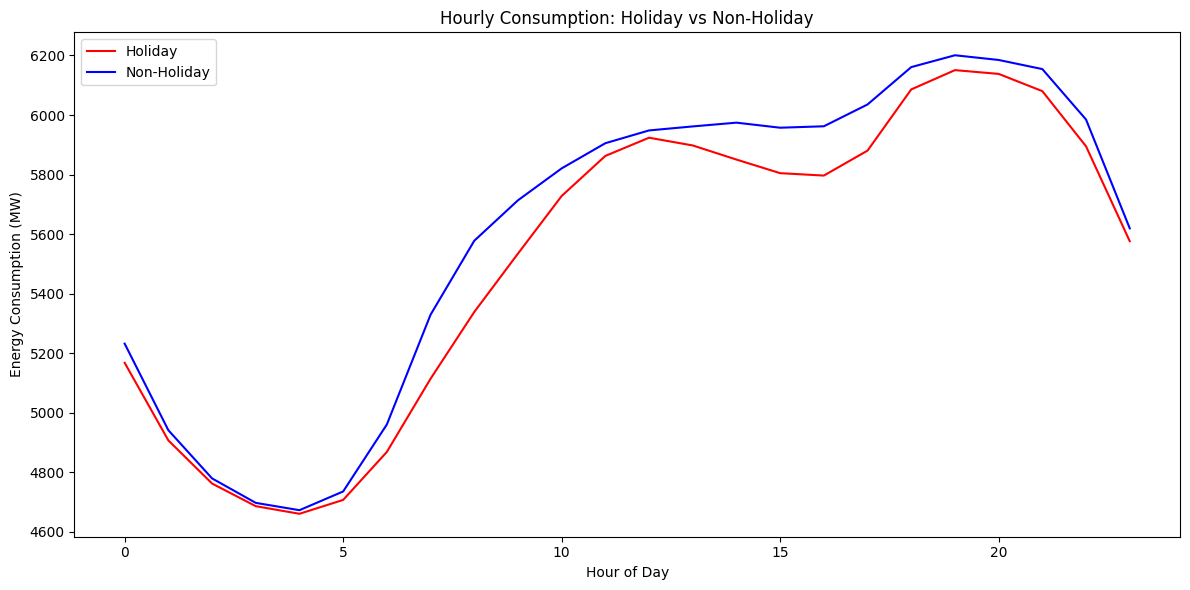

In [17]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# Get US federal holidays in the date range
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=df.index.min(), end=df.index.max())

# Create holiday flag
df['is_holiday'] = pd.to_datetime(df.index.date).isin(holidays)

# Compare holiday vs non-holiday consumption
holiday_avg = df[df['is_holiday']].groupby('hour')['PJMW_MW'].mean()
non_holiday_avg = df[~df['is_holiday']].groupby('hour')['PJMW_MW'].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(holiday_avg.index, holiday_avg.values, label='Holiday', color='red')
plt.plot(non_holiday_avg.index, non_holiday_avg.values, label='Non-Holiday', color='blue')
plt.title('Hourly Consumption: Holiday vs Non-Holiday')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.tight_layout()
plt.show()


 3. Anomaly Detection (Z-Score Method)

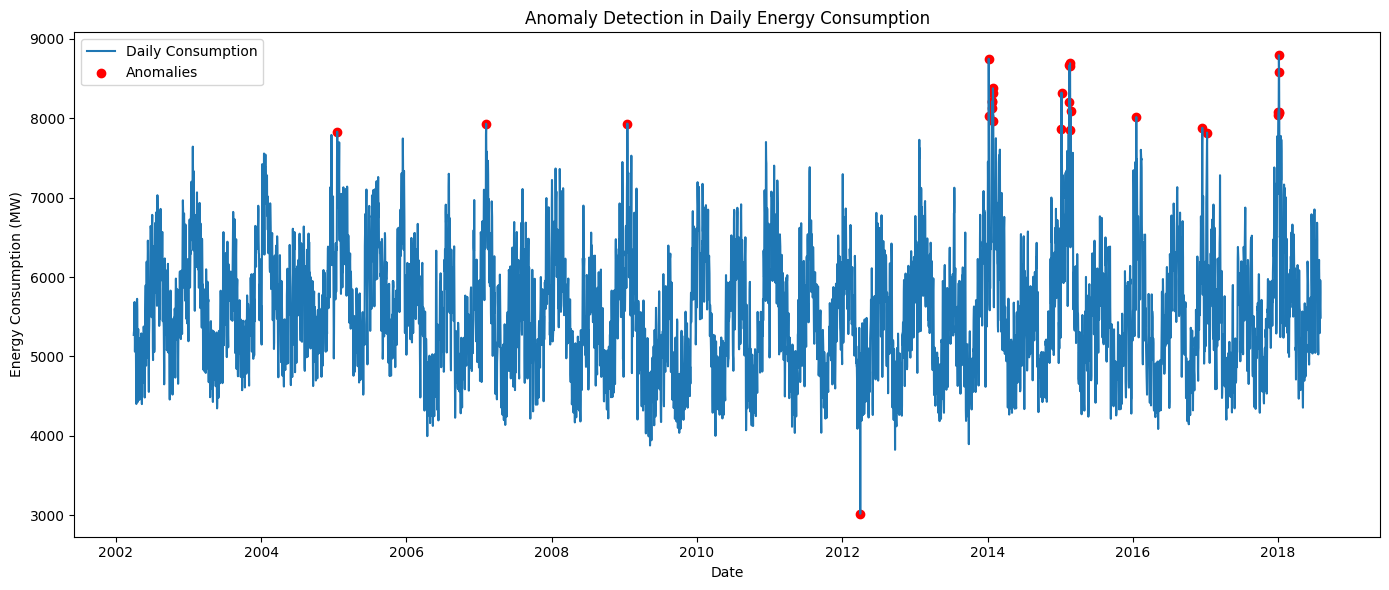

In [18]:
from scipy.stats import zscore

# Resample daily, using the index (Datetime) directly
daily_consumption = df[['PJMW_MW']].resample('D').mean()

# Calculate Z-scores
daily_consumption['z_score'] = zscore(daily_consumption['PJMW_MW'])

# Mark anomalies
threshold = 3  # change if needed
daily_consumption['anomaly'] = daily_consumption['z_score'].abs() > threshold

# Plot anomalies
plt.figure(figsize=(14, 6))
plt.plot(daily_consumption.index, daily_consumption['PJMW_MW'], label='Daily Consumption')
plt.scatter(
    daily_consumption[daily_consumption['anomaly']].index,
    daily_consumption[daily_consumption['anomaly']]['PJMW_MW'],
    color='red', label='Anomalies'
)
plt.title('Anomaly Detection in Daily Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.tight_layout()
plt.show()

**Model** **Building**

1.Arima

RMSE: 715.0834919140102


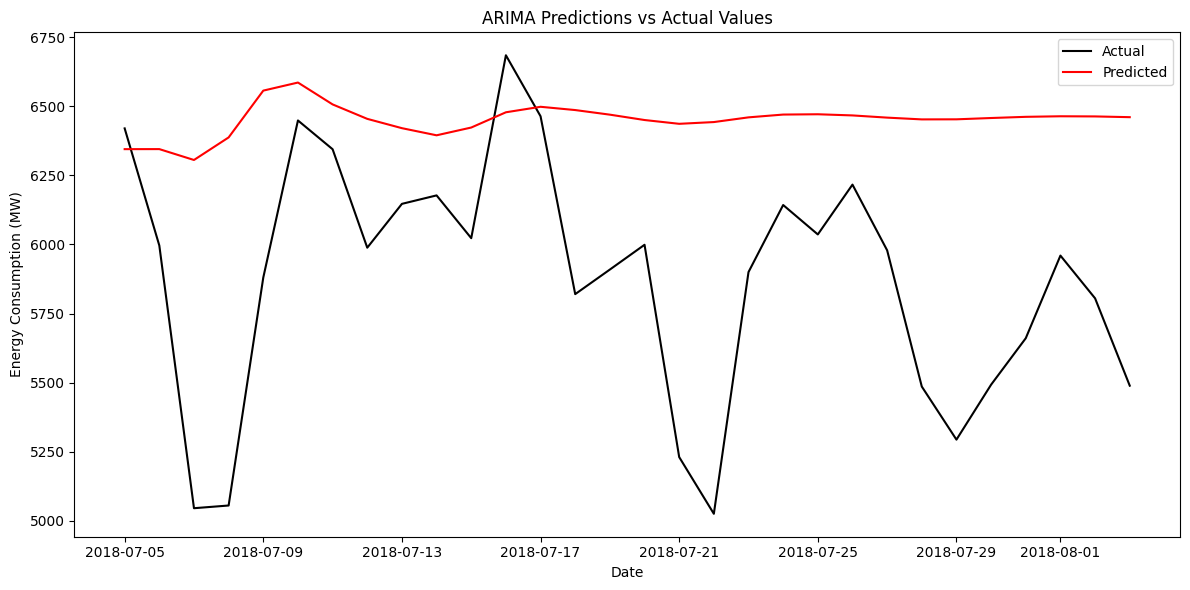

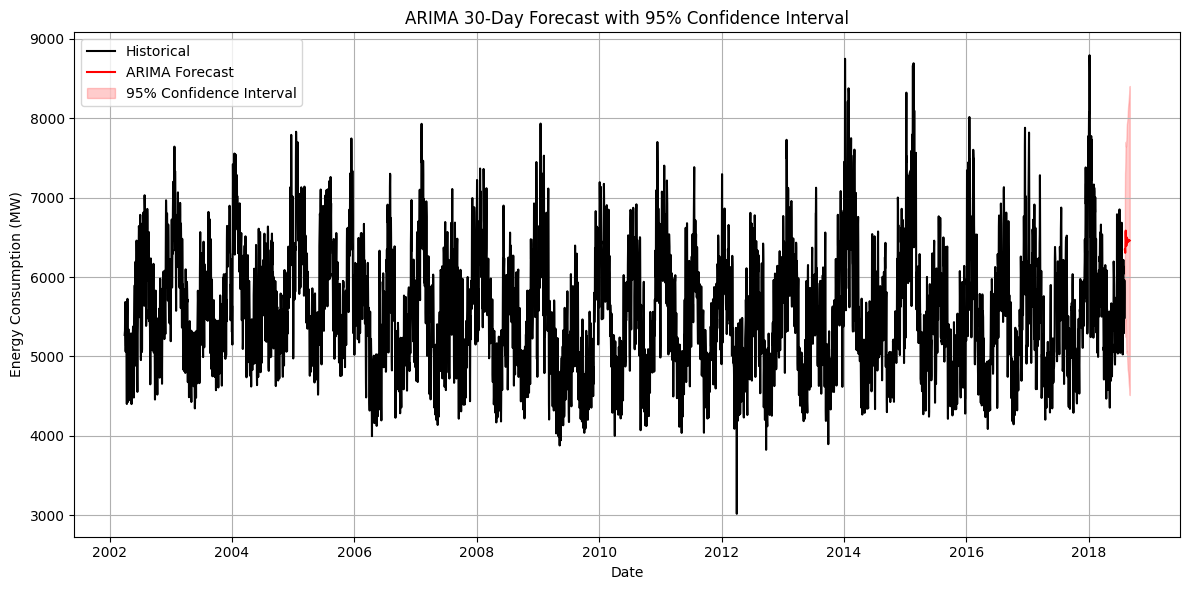

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
train_data = daily_series[:-30]  # Adjust split as needed
test_data = daily_series[-30:]

# Fit ARIMA model
model = ARIMA(train_data, order=(5,1,0))  # Example order (p,d,q), adjust based on ACF/PACF
model_fit = model.fit()

# Make predictions
forecast_steps = 30
forecast_res = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()  # 95% confidence interval

# Evaluate the model (using test data)
predictions = model_fit.predict(start=len(train_data), end=len(daily_series)-1)
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f'RMSE: {rmse}')

# Plot: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual', color='black')
plt.plot(test_data.index, predictions, label='Predicted', color='red')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Forecast with Confidence Interval
future_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(daily_series.index, daily_series, label='Historical', color='black')
plt.plot(future_index, forecast_mean, label='ARIMA Forecast', color='red')
plt.fill_between(future_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('ARIMA 30-Day Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


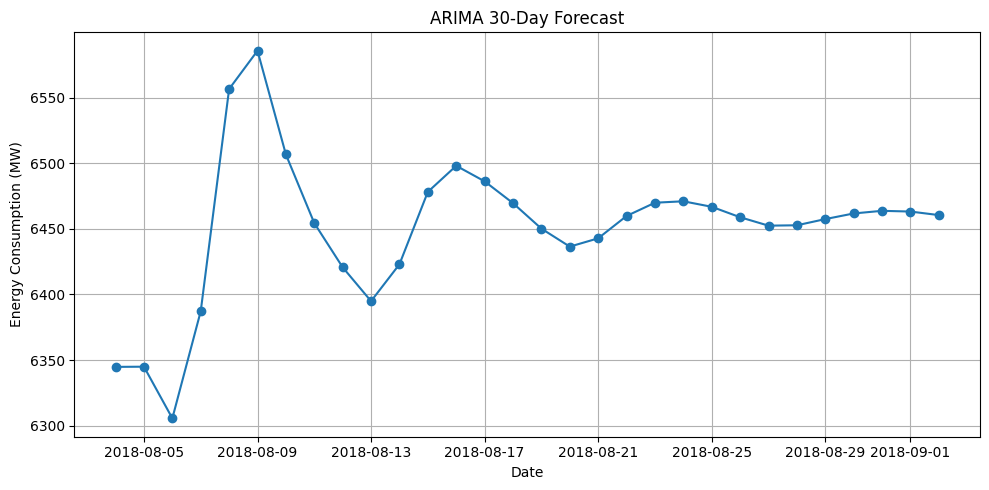

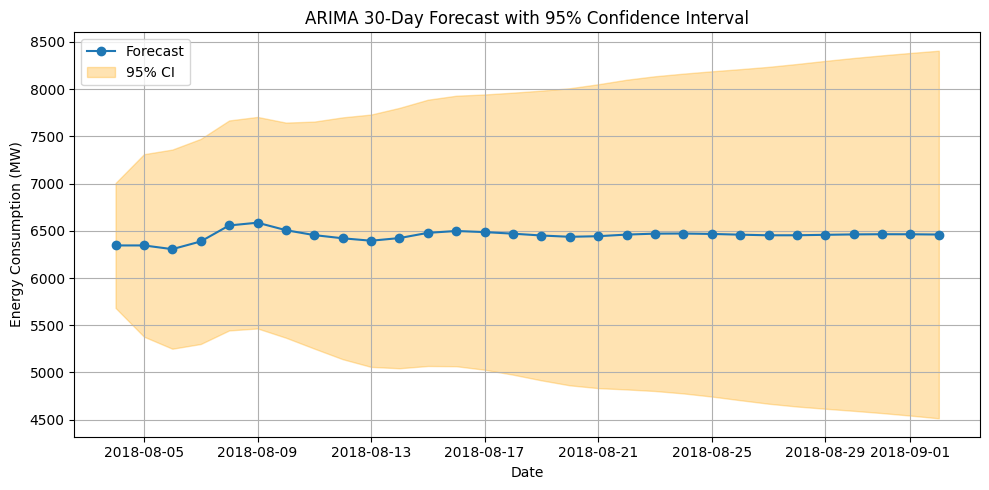

In [20]:
forecast_steps = 30
forecast_res  = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_res.predicted_mean
conf_int      = forecast_res.conf_int()  # DataFrame with lower/upper bounds

# build the 30-day future index
future_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1),
                             periods=forecast_steps)

# 1) Line plot of only the 30‑day forecast
plt.figure(figsize=(10,5))
plt.plot(future_index, forecast_mean, marker='o', linestyle='-')
plt.title('ARIMA 30‑Day Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Forecast plot with 95% CI
plt.figure(figsize=(10,5))
plt.plot(future_index, forecast_mean, marker='o', linestyle='-', label='Forecast')
plt.fill_between(future_index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='orange', alpha=0.3,
                 label='95% CI')
plt.title('ARIMA 30‑Day Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Sarima

SARIMA RMSE: 501.2289588610217


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


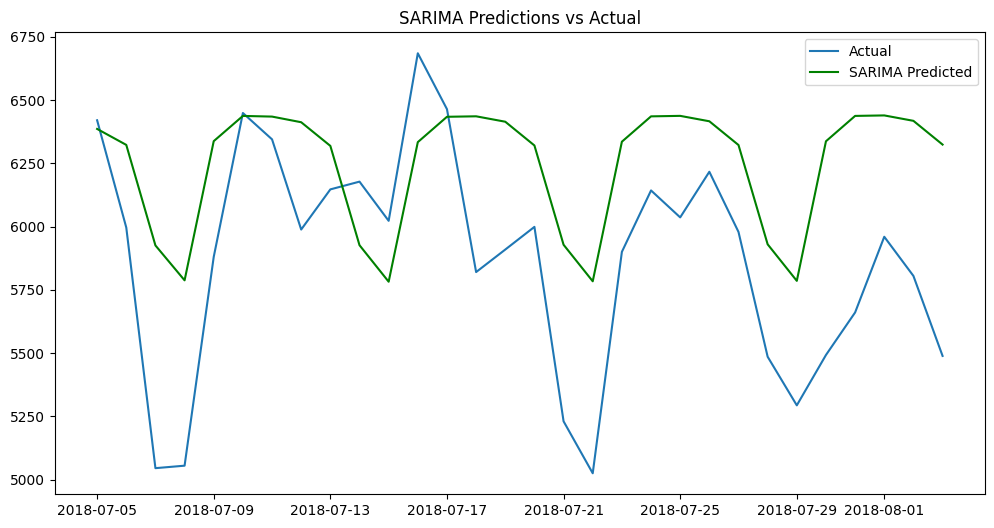

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model (seasonal_order = (P, D, Q, S))
sarima_model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_result = sarima_model.fit()

# Predict
sarima_pred = sarima_result.predict(start=len(train_data), end=len(daily_series)-1, typ='levels')

# Evaluate
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_pred))
print(f'SARIMA RMSE: {sarima_rmse}')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, sarima_pred, label='SARIMA Predicted', color='green')
plt.title('SARIMA Predictions vs Actual')
plt.legend()
plt.show()


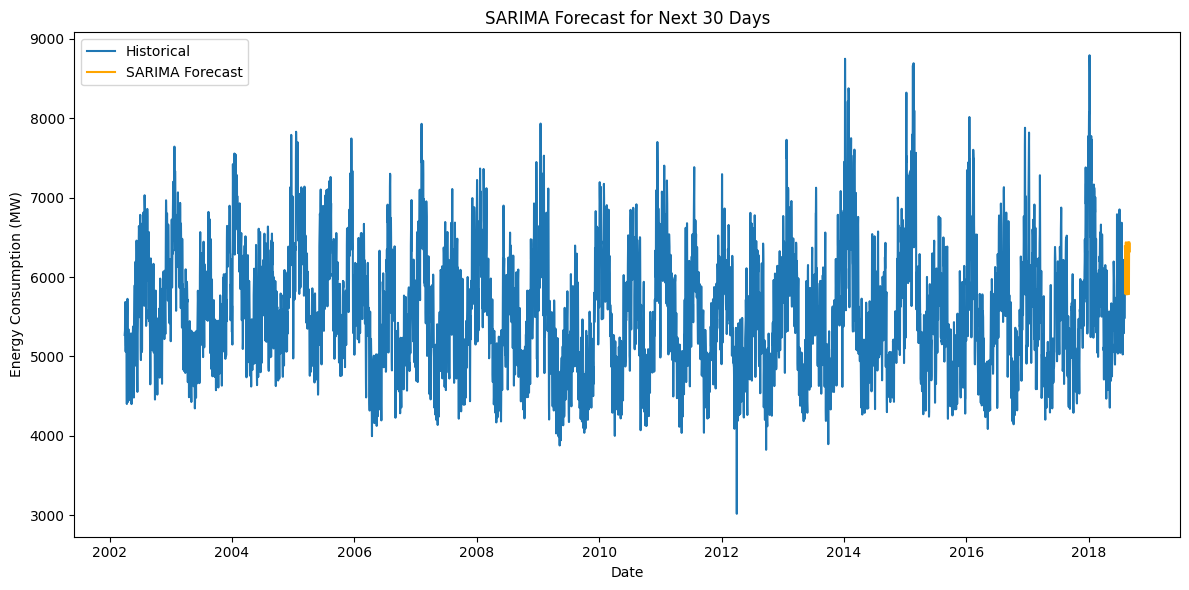

In [22]:
# Forecast next 30 days
sarima_forecast = sarima_result.forecast(steps=30)

# Create future index
future_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_series.index, daily_series, label='Historical')
plt.plot(future_index, sarima_forecast, label='SARIMA Forecast', color='orange')
plt.title('SARIMA Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.tight_layout()
plt.show()


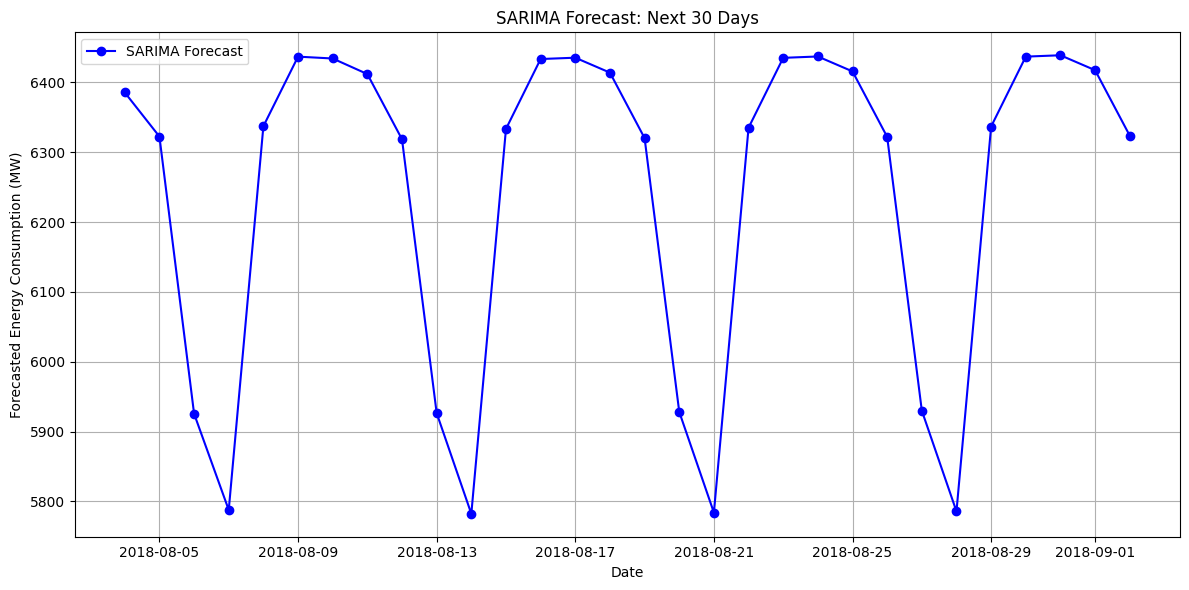

In [23]:
# Forecast next 30 days
sarima_forecast = sarima_result.forecast(steps=30)

# Create future index
future_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot only the 30-day forecast
plt.figure(figsize=(12, 6))
plt.plot(future_index, sarima_forecast, marker='o', linestyle='-', color='blue', label='SARIMA Forecast')
plt.title('SARIMA Forecast: Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Forecasted Energy Consumption (MW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


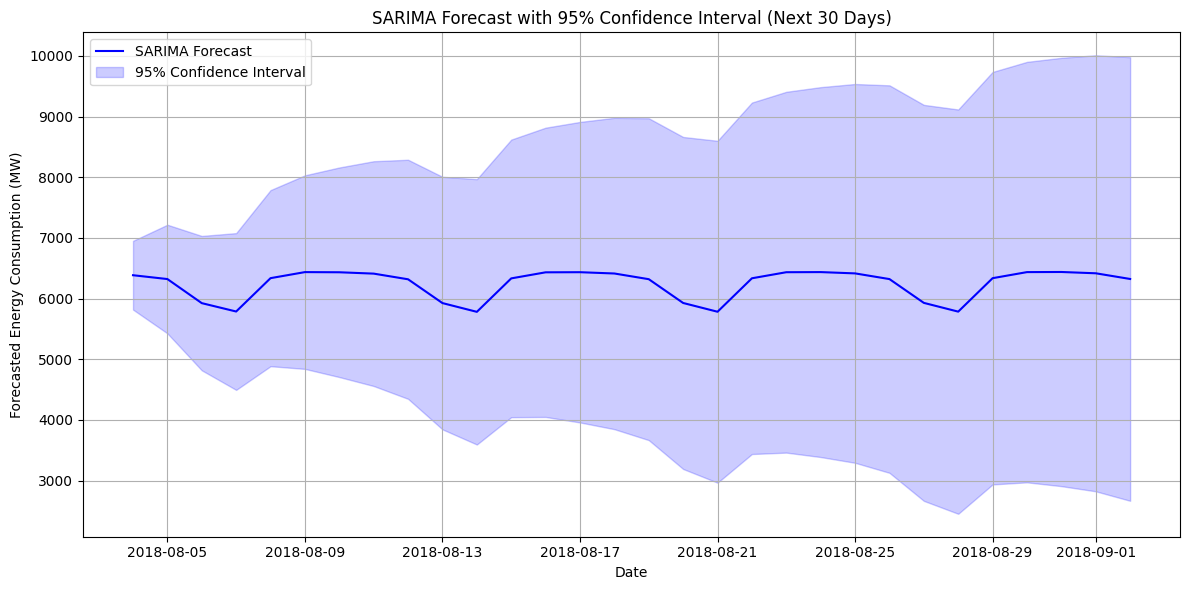

In [24]:
# Get forecast with confidence intervals
sarima_forecast_res = sarima_result.get_forecast(steps=30)
sarima_forecast_mean = sarima_forecast_res.predicted_mean
conf_int = sarima_forecast_res.conf_int()

# Create future date index
future_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(future_index, sarima_forecast_mean, label='SARIMA Forecast', color='blue')
plt.fill_between(future_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title('SARIMA Forecast with 95% Confidence Interval (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Forecasted Energy Consumption (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
LSTM RMSE: 330.88825814698316


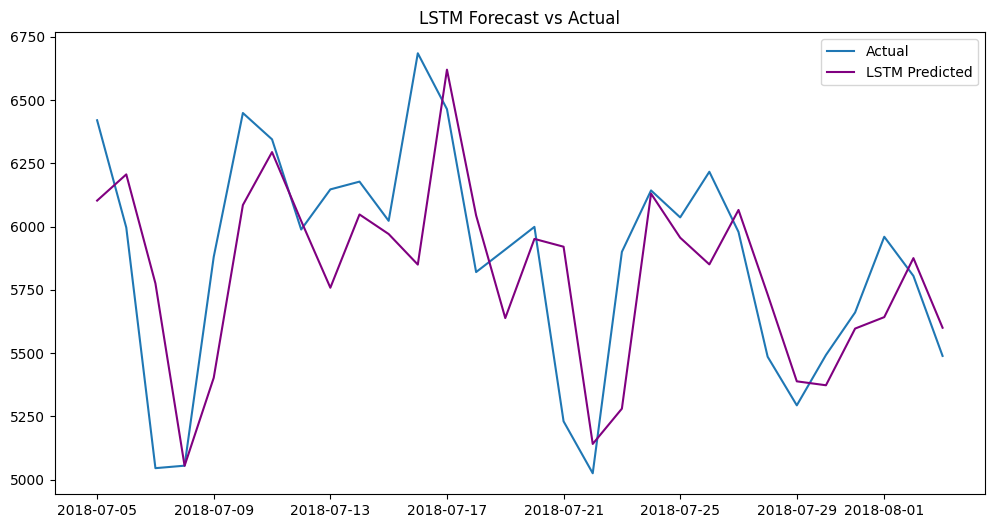

In [25]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_series.values.reshape(-1, 1))

def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
X_train_lstm, X_test_lstm = X[:-30], X[-30:]
y_train_lstm, y_test_lstm = y[:-30], y[-30:]

# Reshape for LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, verbose=0)

# Predict
lstm_pred_scaled = lstm_model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# Evaluate
lstm_rmse = np.sqrt(mean_squared_error(test_data, lstm_pred))
print(f'LSTM RMSE: {lstm_rmse}')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, lstm_pred, label='LSTM Predicted', color='purple')
plt.legend()
plt.title('LSTM Forecast vs Actual')
plt.show()


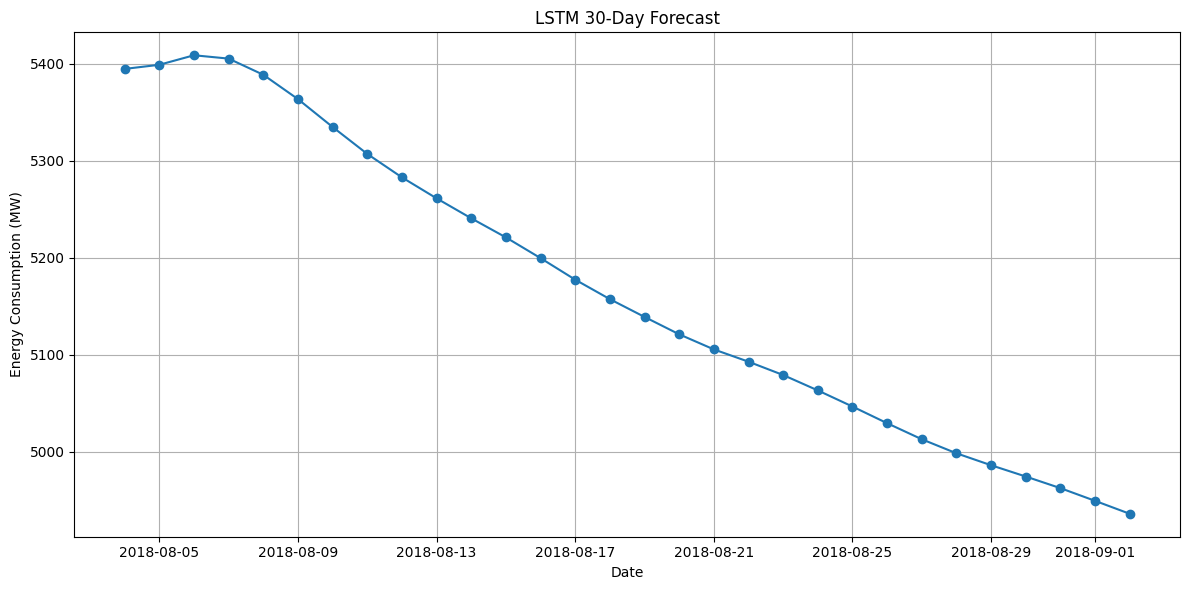

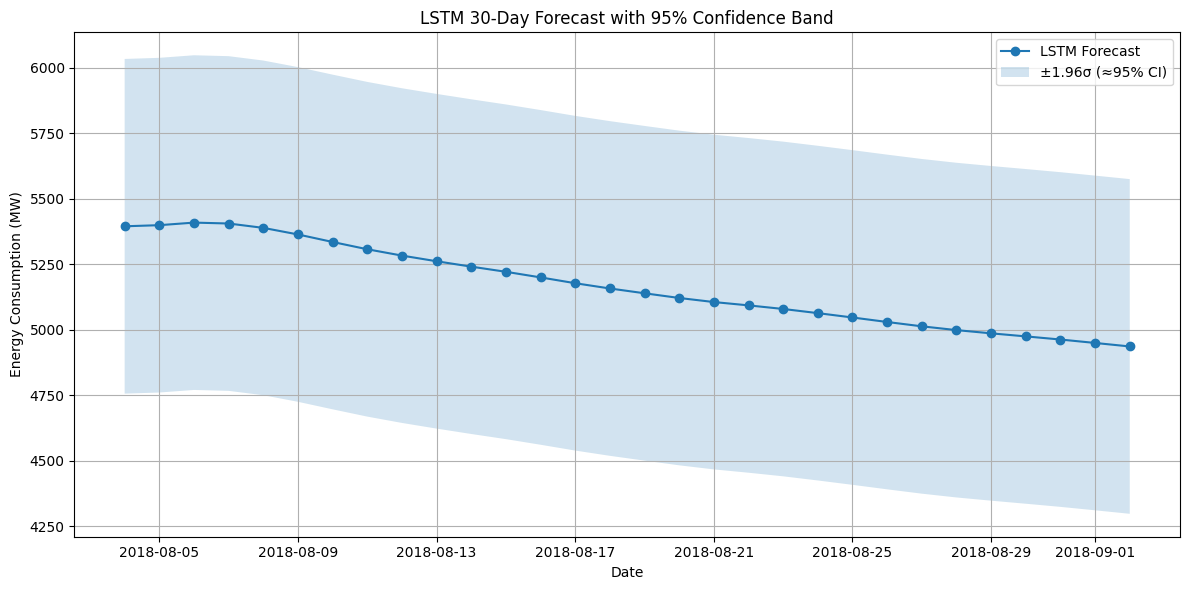

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─── Generate the 30‑day LSTM forecast ─────────────────────────────────────
seq_length = 30
# take the last seq_length points from your scaled series
last_seq = scaler.transform(daily_series.values.reshape(-1, 1))[-seq_length:]
future_preds = []
current_seq = last_seq.reshape(1, seq_length, 1)

for _ in range(30):
    next_scaled = lstm_model.predict(current_seq, verbose=0)       # shape (1,1)
    future_preds.append(next_scaled[0, 0])
    # roll window forward
    current_seq = np.concatenate((current_seq[:, 1:, :], next_scaled.reshape(1,1,1)), axis=1)

# inverse‑scale and build a date index for the next 30 days
future_forecast = scaler.inverse_transform(np.array(future_preds).reshape(-1,1)).flatten()
future_index    = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=30)

# ─── 1) Simple line plot of forecast ────────────────────────────────────────
plt.figure(figsize=(12,6))
plt.plot(future_index, future_forecast, marker='o', linestyle='-')
plt.title('LSTM 30‑Day Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ─── 2) Line + Approximate 95% Confidence Interval ──────────────────────────
# estimate residual spread from your test set
residuals = test_data.values - lstm_pred.flatten()
sigma     = np.std(residuals)
ci_factor = 1.96

upper = future_forecast + ci_factor * sigma
lower = future_forecast - ci_factor * sigma

plt.figure(figsize=(12,6))
plt.plot(future_index, future_forecast, marker='o', linestyle='-',
         label='LSTM Forecast')
plt.fill_between(future_index, lower, upper, alpha=0.2,
                 label='±1.96σ (≈95% CI)')
plt.title('LSTM 30‑Day Forecast with 95% Confidence Band')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


XGboost

XGBoost RMSE: 319.45792637444686


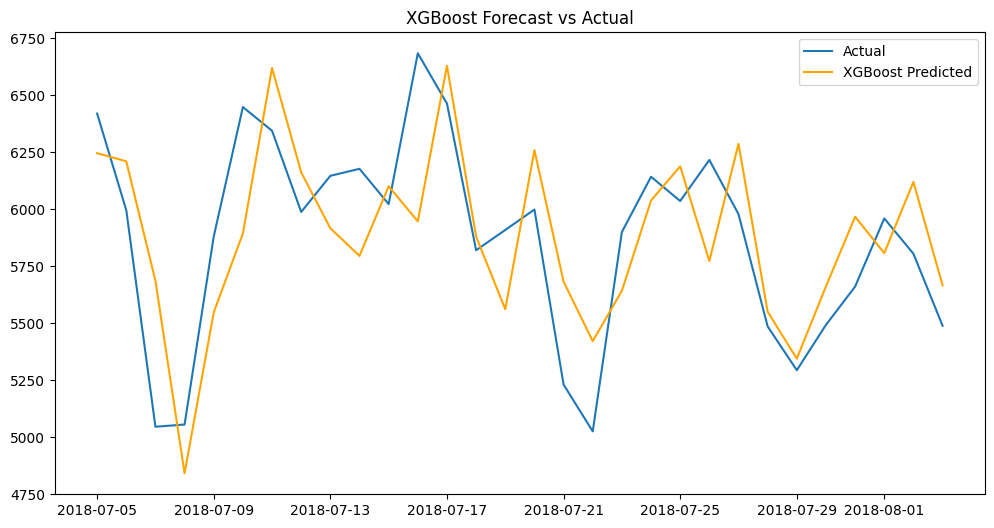

In [27]:
import xgboost as xgb

# Create lag features
df_lag = daily_series.to_frame()
for lag in range(1, 8):
    df_lag[f'lag_{lag}'] = df_lag['PJMW_MW'].shift(lag)
df_lag.dropna(inplace=True)

# Split
X_xgb = df_lag.drop(columns='PJMW_MW')
y_xgb = df_lag['PJMW_MW']
X_train_xgb = X_xgb[:-30]
X_test_xgb = X_xgb[-30:]
y_train_xgb = y_xgb[:-30]
y_test_xgb = y_xgb[-30:]

# Train model
xgb_model = xgb.XGBRegressor(n_estimators=100)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Predict
xgb_pred = xgb_model.predict(X_test_xgb)

# Evaluate
xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, xgb_pred))
print(f'XGBoost RMSE: {xgb_rmse}')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_xgb.index, y_test_xgb, label='Actual')
plt.plot(y_test_xgb.index, xgb_pred, label='XGBoost Predicted', color='orange')
plt.legend()
plt.title('XGBoost Forecast vs Actual')
plt.show()


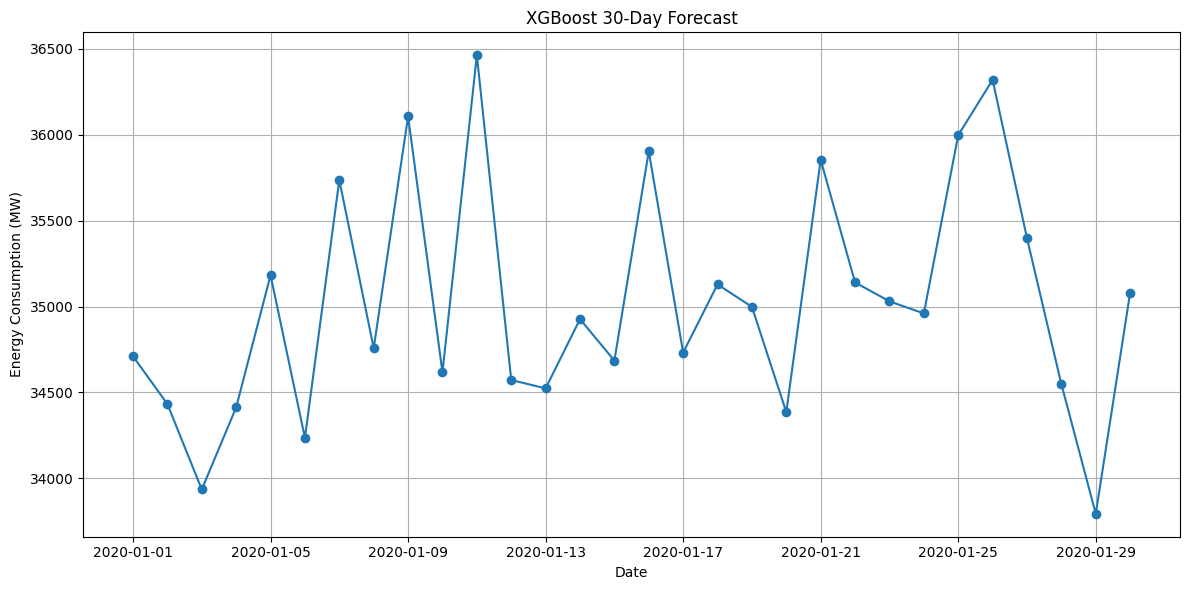

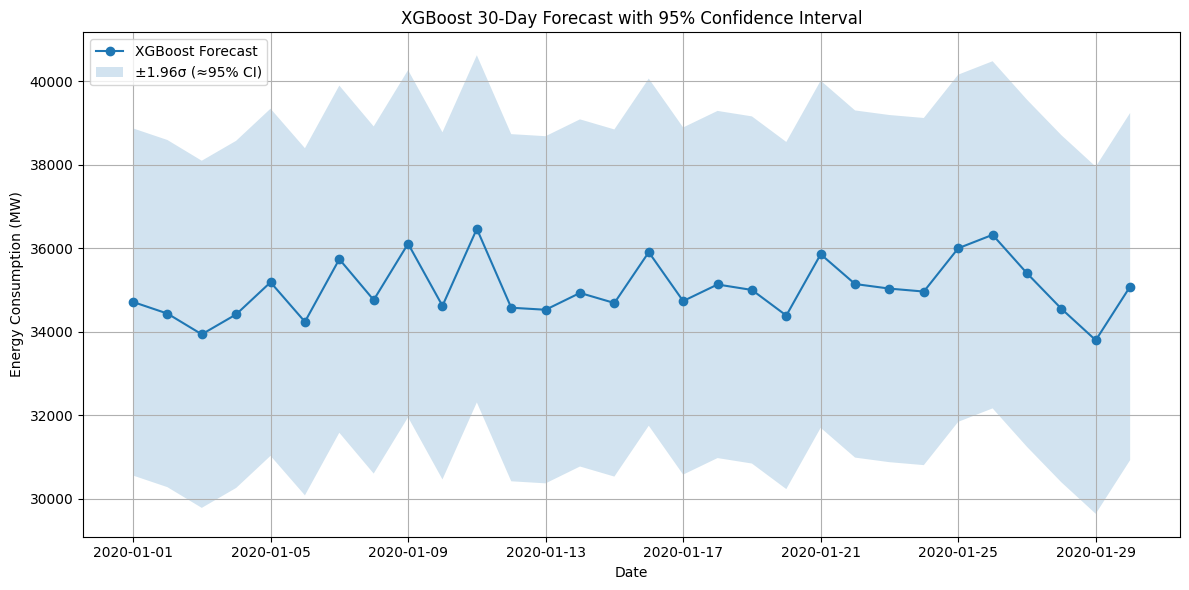

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# 1. Simulate or load your daily_series
date_rng = pd.date_range(start='2015-01-01', end='2019-12-31', freq='D')
np.random.seed(42)
data = np.random.normal(loc=35000, scale=2000, size=len(date_rng))
daily_series = pd.Series(data, index=date_rng, name='PJMW_MW')

# 2. Create lag features
df_lag = daily_series.to_frame()
for lag in range(1, 8):
    df_lag[f'lag_{lag}'] = df_lag['PJMW_MW'].shift(lag)
df_lag.dropna(inplace=True)

# 3. Train/Test split
X = df_lag.drop(columns='PJMW_MW')
y = df_lag['PJMW_MW']
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

# 4. Train XGBoost
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Test predictions and residual σ
y_pred = model.predict(X_test)
residuals = y_test.values - y_pred
sigma = np.std(residuals)
ci_factor = 1.96

# 6. Multi-step 30-day forecast
last_known = df_lag.iloc[-7:].copy()
forecast_values = []
for _ in range(30):
    inp = last_known.iloc[-1][['lag_1','lag_2','lag_3','lag_4','lag_5','lag_6','lag_7']].values.reshape(1, -1)
    val = model.predict(inp)[0]
    forecast_values.append(val)
    prev = last_known.iloc[-1]
    new_lags = [val] + prev[['lag_1','lag_2','lag_3','lag_4','lag_5','lag_6']].tolist()
    new_row = pd.Series([val] + new_lags, index=last_known.columns)

    # Use pd.concat() to add the new row
    last_known = pd.concat([last_known, new_row.to_frame().T], ignore_index=True)

future_index = pd.date_range(start=y_test.index[-1] + pd.Timedelta(days=1), periods=30)
forecast = np.array(forecast_values)

# Plot 1: Simple line
plt.figure(figsize=(12,6))
plt.plot(future_index, forecast, marker='o', linestyle='-', label='XGBoost Forecast')
plt.title('XGBoost 30‑Day Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: With ±1.96σ CI
upper = forecast + ci_factor * sigma
lower = forecast - ci_factor * sigma

plt.figure(figsize=(12,6))
plt.plot(future_index, forecast, marker='o', linestyle='-', label='XGBoost Forecast')
plt.fill_between(future_index, lower, upper, alpha=0.2, label='±1.96σ (≈95% CI)')
plt.title('XGBoost 30‑Day Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
import joblib
joblib.dump(xgb_model, 'xgb_pjm_model.pkl')

['xgb_pjm_model.pkl']

Streamlit deployment

In [33]:
!pip install streamlit

In [37]:
!wget -q -O - ipv4.icanhazip.com

34.90.114.204


In [38]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.90.114.204:8501

⠼⠴your url is: https://eleven-trees-jog.loca.lt
  Stopping...
^C
